# LoRA Fine-tuning of ViT Model for NZ Bird Sound Classification

In [1]:
from datasets import load_dataset, DatasetDict, Audio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoImageProcessor, AutoModelForImageClassification, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
import os
import torch
from peft import PeftModel, LoraConfig, get_peft_model
import evaluate
import numpy as np
from collections import Counter
from PIL import Image
import random
from collections import defaultdict
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

model_name = "google/vit-base-patch16-224-in21k"
segments_dir = "./segments" # Directory containing the segmented audio files (segments/{bird_name}/{recording_name}.wav)
output_dir = "./vit-base-manuai"

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load datasets
# Directory structure:
# segments/
#   ├── tui/
#   ├── bellbird/
#   ├── kaka/
    #   ├── {scientific_name}_{scientific_subspecies}/
    #   │   ├── {id}_{english_name}_{scientific_name}_{scientific_subspecies}_call_segment_0.wav
    #   │   ├── {id}_{english_name}_{scientific_name}_{scientific_subspecies}_call_segment_1.wav
    #   │   ├── {id}_{english_name}_{scientific_name}_{scientific_subspecies}_call_segment_2.wav
#   ├── etc.

dataset = load_dataset(
    "audiofolder",
    data_dir=segments_dir,
    split="train",
)

# Set audio feature to not decode automatically to avoid torchcodec dependency
dataset = dataset.cast_column("audio", Audio(decode=False))

print(f"Loaded dataset with {len(dataset)} examples")

Loaded dataset with 28706 examples


In [3]:
def convert_to_mel_spectrogram(example):
    audio_path = example["audio"]["path"]
    y, sr = librosa.load(audio_path, sr=44100) # 44.1 kHz is a common sampling rate for bird sounds
    mel_spectrogram = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=128, # Number of mel bands (more bands can capture more detail)
        n_fft=2048, # FFT window size 
        hop_length=512, # Hop length for STFT
        win_length=2048, # Window length for STFT
        window='hann', # Window function
        fmin=50, # Minimum frequency
        fmax=sr//2 # Maximum frequency (Nyquist frequency for the given sample rate)
    )
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=1.0) # Convert to dB scale
    
    # Convert to PIL Image instead of list
    # Normalize the spectrogram to 0-255 range for image processing
    normalized = ((mel_spectrogram_db - mel_spectrogram_db.min()) / 
                 (mel_spectrogram_db.max() - mel_spectrogram_db.min()) * 255).astype(np.uint8)
    
    # Convert to 3-channel image (RGB) by repeating the grayscale values
    rgb_image = np.stack([normalized] * 3, axis=0)  # Shape: (3, height, width)
    rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Shape: (height, width, 3)
    
    example["image"] = Image.fromarray(rgb_image)
    return example

def convert_to_linear_spectrogram(example):
    audio_path = example["audio"]["path"]
    y, sr = librosa.load(audio_path, sr=44100)  # Load audio at 44.1 kHz
    linear_spectrogram = librosa.stft(y, n_fft=2048, hop_length=512, win_length=2048)
    linear_spectrogram_db = librosa.amplitude_to_db(np.abs(linear_spectrogram), ref=np.max)
    
    # Convert to PIL Image instead of list
    normalized = ((linear_spectrogram_db - linear_spectrogram_db.min()) / 
                 (linear_spectrogram_db.max() - linear_spectrogram_db.min()) * 255).astype(np.uint8)
    
    # Convert to 3-channel image (RGB) by repeating the grayscale values
    rgb_image = np.stack([normalized] * 3, axis=0)  # Shape: (3, height, width)
    rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Shape: (height, width, 3)
    
    example["image"] = Image.fromarray(rgb_image)
    return example

def extract_bird_name_from_filename(example):
    """
    Extract the English bird name from the filename.
    Filename format: {file_id}_{english_name}_{scientific_specie}_{scientific_subspecie}_{song or call}.wav
    We want the {english_name} part (second element after splitting by underscore).
    """
    audio_path = example["audio"]["path"]
    # Get just the filename without the path
    filename = os.path.basename(audio_path)
    # Remove the .wav extension
    filename_without_ext = os.path.splitext(filename)[0]
    # Split by underscore and get the english name (second element)
    parts = filename_without_ext.split('_')
    if len(parts) >= 2:
        english_name = parts[1]  # Second element is the English name
    else:
        # Fallback if filename doesn't match expected format
        english_name = "unknown"
    
    example["class"] = english_name
    return example

# STEP 1: Extract bird names from filenames (fast operation)
print("Extracting bird names from filenames...")
dataset = dataset.map(
    extract_bird_name_from_filename,
    remove_columns=["label"],
    desc="Extracting bird names from filenames"
)

# STEP 2: Get class distribution to show user options
print("Analyzing class distribution...")
temp_dataset = dataset.with_format(None)
all_classes = [item['class'] for item in temp_dataset]
class_counts = Counter(all_classes)

print("Class Distribution:")
print("=" * 50)
total_samples = sum(class_counts.values())

# Sort by count (descending) for better visualisation
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

for bird_class, count in sorted_classes:
    percentage = (count / total_samples) * 100
    print(f"{bird_class:12}: {count:5,} ({percentage:5.1f}%)")

print("=" * 50)
print(f"{'Total':12}: {total_samples:5,} (100.0%)")
print(f"{'Classes':12}: {len(class_counts):5}")

# Check for class imbalance
max_count = max(class_counts.values())
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count

print(f"\nClass Balance Analysis:")
print(f"    - Most samples: {max_count:,} ({sorted_classes[0][0]})")
print(f"    - Least samples: {min_count:,} ({sorted_classes[-1][0]})")
print(f"    - Imbalance ratio: {imbalance_ratio:.1f}:1")

# STEP 3: Memory-safe recommendations
print(f"\n🔥 MEMORY SAFETY RECOMMENDATIONS:")
print(f"   - For testing: 10-50 samples per class")
print(f"   - For development: 100-200 samples per class") 
print(f"   - For full training: 500+ samples per class")
print(f"   - Available range: min = {min_count}, max = {max_count}")
print(f"   - Total classes: {len(class_counts)}")

# Calculate safe recommendations based on dataset size
total_files = len(dataset)
if total_files > 20000:
    recommended_max = 100
    warning = "⚠️  LARGE DATASET: Strongly recommend 100 or fewer per class"
elif total_files > 10000:
    recommended_max = 200
    warning = "⚠️  MEDIUM DATASET: Recommend 200 or fewer per class"
else:
    recommended_max = 500
    warning = "✅ Dataset size manageable"

print(f"   💡 Based on {total_files:,} total files: {warning}")
print(f"   💡 Recommended max: {recommended_max} per class")

# STEP 4: Get user input for filtering
num_spectrograms_per_class = int(input(f"Enter spectrograms per class (0 for all, recommended: {recommended_max}): "))

# STEP 5: Filter dataset BEFORE spectrogram conversion
if num_spectrograms_per_class > 0:
    print(f"Filtering to {num_spectrograms_per_class} samples per class...")
    
    # Group indices by class efficiently
    class_to_indices = defaultdict(list)
    for idx, item in enumerate(temp_dataset):
        class_to_indices[item['class']].append(idx)
    
    selected_indices = []
    for cls, indices in class_to_indices.items():
        np.random.shuffle(indices)
        selected_count = min(num_spectrograms_per_class, len(indices))
        selected_indices.extend(indices[:selected_count])
        print(f"   {cls}: selected {selected_count} / {len(indices)} samples")
    
    # Sort indices for efficient dataset selection
    selected_indices = sorted(selected_indices)
    
    print(f"Filtering dataset from {len(dataset):,} to {len(selected_indices):,} samples...")
    dataset = dataset.select(selected_indices)
    
    # Clean up intermediate variables
    del class_to_indices, selected_indices, temp_dataset
    
    print(f"✅ Dataset filtered successfully!")
    print(f"   New dataset size: {len(dataset):,}")
else:
    print("⚠️  WARNING: Using all spectrograms - high memory usage expected!")
    if len(dataset) > 10000:
        print("   🚨 RISK: Large dataset may cause kernel crashes")

# STEP 6: Now convert spectrograms (only for the filtered dataset)
print(f"\n🎵 Converting {len(dataset):,} audio files to spectrograms...")
print("This may take a few minutes depending on dataset size...")

dataset = dataset.map(
    convert_to_mel_spectrogram,
    remove_columns=["audio"],
    desc="Converting to mel spectrograms"
)

print("✅ Spectrogram conversion completed!")

# dataset = dataset.map(
#     convert_to_linear_spectrogram,
#     remove_columns=["audio"],
#     desc="Converting to linear spectrograms"
# )

dataset

Extracting bird names from filenames...
Analyzing class distribution...
Class Distribution:
tui         : 11,407 ( 39.7%)
bellbird    : 4,559 ( 15.9%)
robin       : 2,315 (  8.1%)
silvereye   : 1,939 (  6.8%)
whitehead   : 1,817 (  6.3%)
fantail     : 1,660 (  5.8%)
kaka        : 1,532 (  5.3%)
saddleback  : 1,331 (  4.6%)
tomtit      : 1,186 (  4.1%)
morepork    :   960 (  3.3%)
Total       : 28,706 (100.0%)
Classes     :    10

Class Balance Analysis:
    - Most samples: 11,407 (tui)
    - Least samples: 960 (morepork)
    - Imbalance ratio: 11.9:1

🔥 MEMORY SAFETY RECOMMENDATIONS:
   - For testing: 10-50 samples per class
   - For development: 100-200 samples per class
   - For full training: 500+ samples per class
   - Available range: min = 960, max = 11407
   - Total classes: 10
   💡 Based on 28,706 total files: ⚠️  LARGE DATASET: Strongly recommend 100 or fewer per class
   💡 Recommended max: 100 per class
Filtering to 100 samples per class...
   bellbird: selected 100 / 4559 sa

Converting to mel spectrograms: 100%|██████████| 1000/1000 [00:12<00:00, 77.54 examples/s]

✅ Spectrogram conversion completed!


Dataset({
    features: ['class', 'image'],
    num_rows: 1000
})

In [4]:
train, test = dataset.train_test_split(test_size=0.2, seed=42).values()

dataset_dict = DatasetDict({
    "train": train,
    "test": test,
})

# Access spectrogram path instead of decoded audio to avoid torchcodec
print(f"Number of training samples: {len(dataset_dict['train'])}")
print(f"Number of test samples: {len(dataset_dict['test'])}")
print(f"Sample spectrogram path: {dataset_dict['train'][10]['image'].filename}")  # Show path to the spectrogram image
print(f"Sample class: {dataset_dict['train'][10]['class']}")  # Show class label

# Show the dataset structure
print(f"\nDataset features: {dataset_dict['train'].features}")

Number of training samples: 800
Number of test samples: 200
Sample spectrogram path: 
Sample class: kaka

Dataset features: {'class': Value('string'), 'image': Image(mode=None, decode=True)}


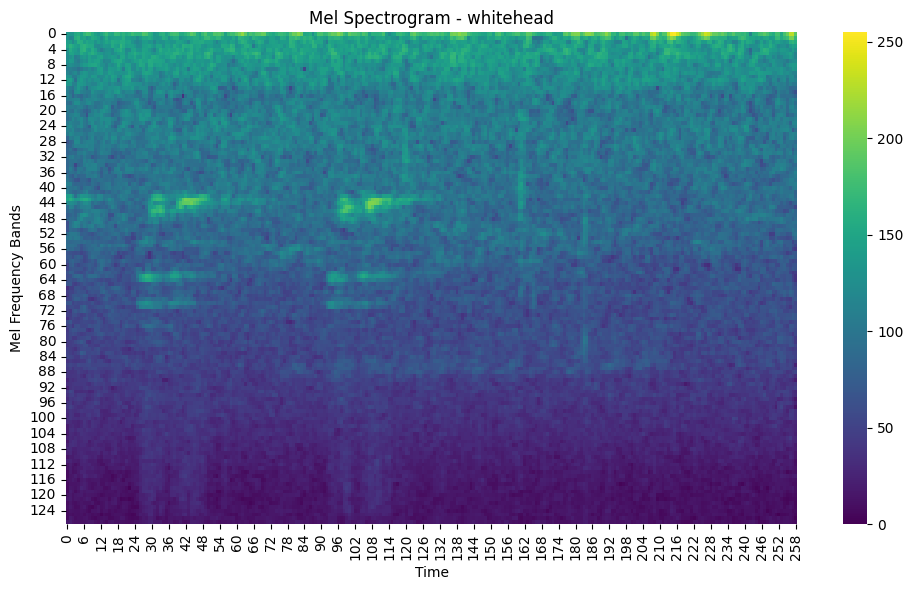

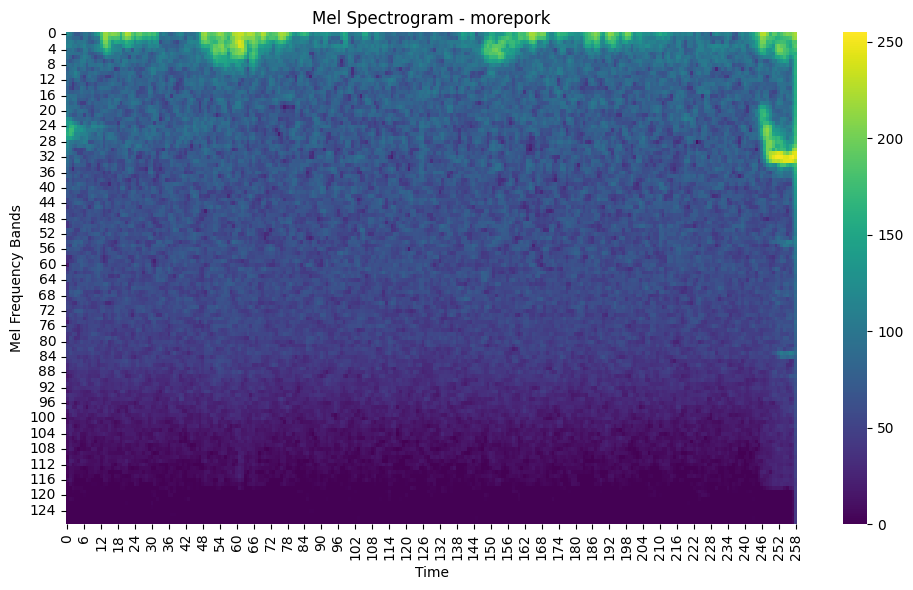

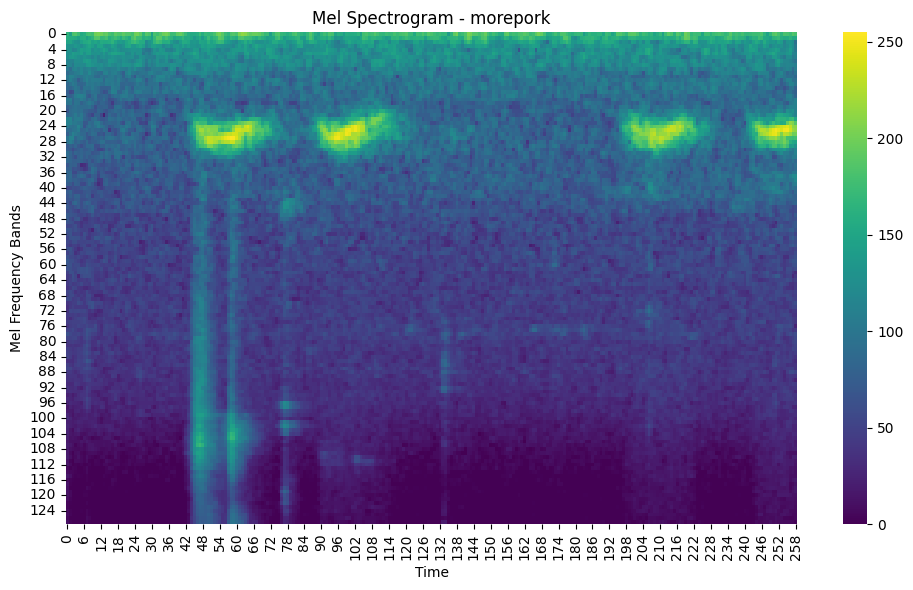

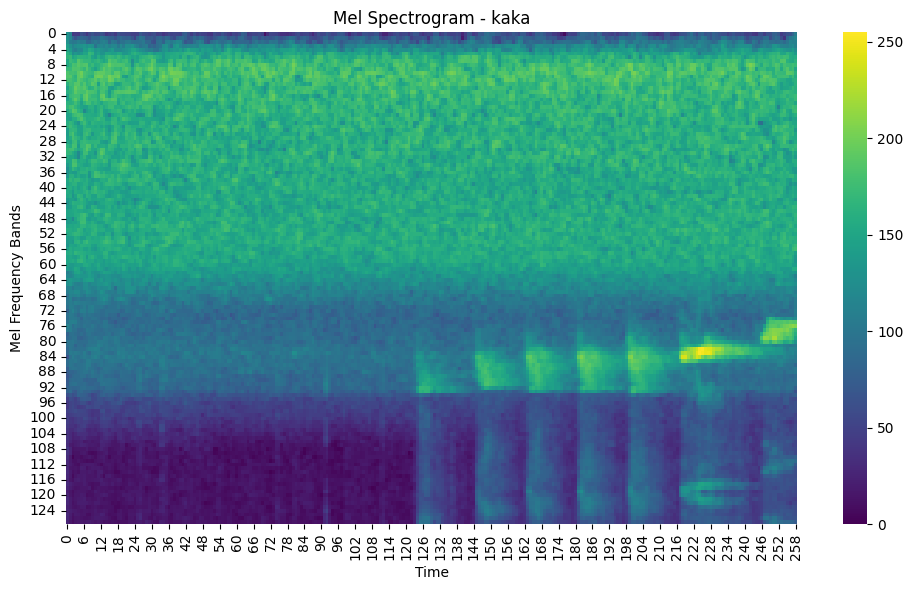

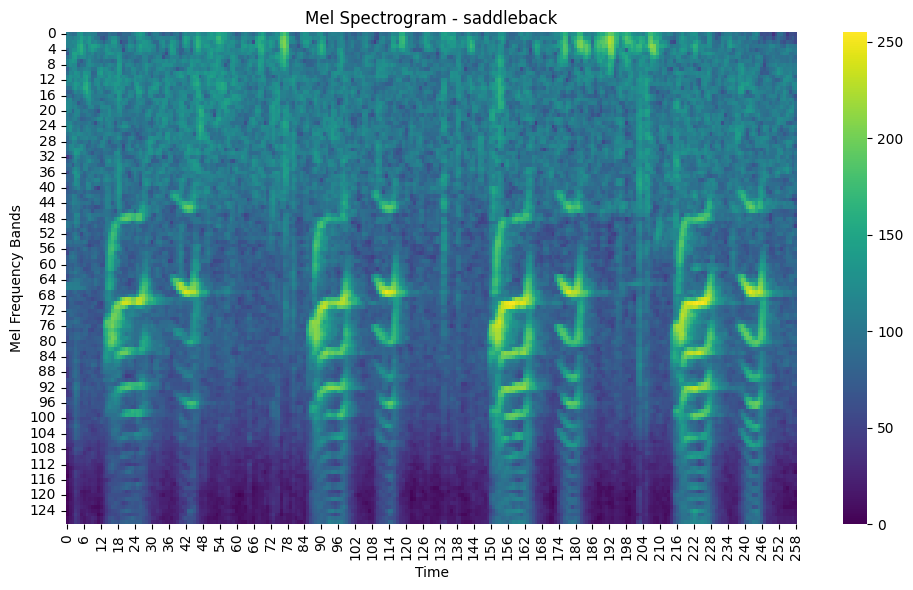

In [5]:
# Plotting mel spectrograms for visualization
def plot_spectrogram(spectrogram, title="Mel Spectrogram"):
    # Convert PIL Image to numpy array and extract single channel for heatmap
    if isinstance(spectrogram, Image.Image):
        spectrogram_array = np.array(spectrogram)
    else:
        spectrogram_array = spectrogram
    
    # If it's RGB (3 channels), take only the first channel since all channels are identical
    if len(spectrogram_array.shape) == 3:
        spectrogram_2d = spectrogram_array[:, :, 0]  # Take first channel
    else:
        spectrogram_2d = spectrogram_array
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(spectrogram_2d, cmap='viridis', cbar=True)
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency Bands')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot a few mel spectrograms from the training set
for i in range(5):  # Show first 5 examples
    spectrogram = dataset_dict['train'][i]['image']
    bird_class = dataset_dict['train'][i]['class']
    plot_spectrogram(spectrogram, title=f"Mel Spectrogram - {bird_class}")

In [6]:
# Quick Dataset Summary (detailed analysis was done during filtering)
temp_train = dataset_dict['train'].with_format(None)
all_classes = [item['class'] for item in temp_train]
class_counts = Counter(all_classes)

print("📋 Final Dataset Summary:")
print("=" * 40)
total_samples = sum(class_counts.values())

# Sort by count (descending)
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

for bird_class, count in sorted_classes:
    percentage = (count / total_samples) * 100
    print(f"{bird_class:12}: {count:5,} ({percentage:5.1f}%)")

print("=" * 40)
print(f"{'Total':12}: {total_samples:5,} (100.0%)")
print(f"{'Classes':12}: {len(class_counts):5}")

# Store these for use in later cells
max_count = max(class_counts.values())
min_count = min(class_counts.values())

print(f"\n✅ Ready for visualization and training!")

📋 Final Dataset Summary:
morepork    :    87 ( 10.9%)
saddleback  :    84 ( 10.5%)
kaka        :    82 ( 10.2%)
robin       :    80 ( 10.0%)
tomtit      :    80 ( 10.0%)
silvereye   :    80 ( 10.0%)
bellbird    :    79 (  9.9%)
tui         :    78 (  9.8%)
fantail     :    76 (  9.5%)
whitehead   :    74 (  9.2%)
Total       :   800 (100.0%)
Classes     :    10

✅ Ready for visualization and training!


In [7]:
# Dataset Status Check - Filtering already done in previous cell
print("Current Dataset Status:")
print(f"    - Total samples: {len(dataset_dict['train']) + len(dataset_dict['test']):,}")
print(f"    - Training samples: {len(dataset_dict['train']):,}")
print(f"    - Test samples: {len(dataset_dict['test']):,}")

# Quick class distribution check
temp_train = dataset_dict['train'].with_format(None)
current_classes = Counter([item['class'] for item in temp_train])
print(f"Number of classes: {len(current_classes)}")
print(f"Classes: {list(current_classes.keys())}")

print("\nDataset ready for training!")

Current Dataset Status:
    - Total samples: 1,000
    - Training samples: 800
    - Test samples: 200
Number of classes: 10
Classes: ['whitehead', 'morepork', 'kaka', 'saddleback', 'fantail', 'bellbird', 'tui', 'robin', 'tomtit', 'silvereye']

Dataset ready for training!


In [8]:
image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

# pipeline for preprocessing images to get same shape and scaling
preprocess_image = Compose([
    Resize(image_processor.size["height"]),
    CenterCrop(image_processor.size["height"]),
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std),
])

# function to apply above preprocessing to a batch (train or test)
def preprocess(batch):
    batch["pixel_values"] = [
        preprocess_image(image.convert("RGB")) for image in batch["image"]
    ]
    return batch

# Set the transform for the datasets
dataset_dict["train"].set_transform(preprocess)
dataset_dict["test"].set_transform(preprocess)

print(f"Training set size: {len(dataset_dict['train'])}, Test set size: {len(dataset_dict['test'])}")

Training set size: 800, Test set size: 200


In [9]:
def print_model_size(path):
    size = 0
    for f in os.scandir(path):
        size += os.path.getsize(f)

    print(f"Model Size: {(size / 1e6):.2} MB")


def print_trainable_parameters(model, label):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    print(f"{label} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)")


In [10]:
metric = evaluate.load("accuracy")

# # if you want to use quantized lora fine-tuning
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16,
#     bnb_4bit_quant_storage=torch.uint8,  # Use uint8 for quantization storage (more efficient than bfloat16 for quantization)
# )

def data_collator(batch):
    """
    Custom data collator to handle batches of images and labels.
    Converts pixel values to tensors and labels to a tensor.
    """
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}


def compute_metrics(eval_pred):
    """    
    Compute accuracy metrics for the evaluation predictions.
    Extracts predictions and computes accuracy using the evaluate library.
    """
    eval_pred = eval_pred
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)


def get_base_model(label2id, id2label):
    """    
    Load the base model for image classification.
    This function initializes the model with the specified label mappings.
    """
    print(f"Loading base model: {model_name}")
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True,
        # quantization_config=bnb_config,
        device_map="auto",
        torch_dtype=torch.bfloat16,  # Use bfloat16 for better performance on supported hardware
    )
    return model


# Custom trainer class to handle class weights properly
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        """
        Computes the loss with optional class weights.
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            # Ensure class weights have the same dtype as the logits
            device_weights = self.class_weights.to(logits.device, dtype=logits.dtype)
            loss_fct = torch.nn.CrossEntropyLoss(weight=device_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss_fct = torch.nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss


def build_lora_model(label2id, id2label):
    """
    Build the LoRA model for fine-tuning.
    This function initializes the base model and applies LoRA configuration.
    """
    print("Building LoRA model...")
    base_model = get_base_model(label2id, id2label)
    print_trainable_parameters(base_model, label="Base Model")

    config = LoraConfig(
        r=16, # Rank of the LoRA layers
        lora_alpha=16, # Scaling factor for the LoRA layers
        target_modules=["query", "value"], # Target modules for LoRA
        lora_dropout=0.1, # Dropout rate for LoRA layers
        bias="none", # No bias in LoRA layers
        modules_to_save=["classifier"], # Modules to save during LoRA fine-tuning
        use_rslora=True,  # Use RSLORA for better performance
    )

    lora_model = get_peft_model(base_model, config)
    print_trainable_parameters(lora_model, label="LoRA")

    return lora_model

In [11]:
# Calculate class weights 
try:
    print("Calculating class weights...")

    if 'dataset_dict' not in locals():
        print("ERROR: dataset_dict not found. Please run the dataset loading cells first.")
        raise NameError("dataset_dict is not defined")
    
    # Get a smaller sample for class distribution analysis
    sample_size = min(5000, len(dataset_dict['train']))  # Use max 5000 samples
    print(f"Using {sample_size} samples out of {len(dataset_dict['train'])} for class weight calculation")
    
    # Create indices for sampling
    random.seed(42)
    all_indices = list(range(len(dataset_dict['train'])))
    sample_indices = random.sample(all_indices, sample_size)
    
    # Get classes from the sample without loading the full dataset transforms
    temp_train = dataset_dict['train'].with_format(None)
    sample_classes = [temp_train[i]['class'] for i in sample_indices]
    
    # Get unique classes from the full dataset (fast operation)
    print("Getting unique classes...")
    all_classes_sample = [temp_train[i]['class'] for i in range(min(10000, len(temp_train)))]
    unique_classes = sorted(set(all_classes_sample))
    print(f"Found {len(unique_classes)} unique classes: {unique_classes}")
    
    # Create label mappings
    label2id = {name: i for i, name in enumerate(unique_classes)}
    id2label = {i: name for i, name in enumerate(unique_classes)}
    
    # Convert class names to indices for compute_class_weight
    y_indices = [label2id[cls] for cls in sample_classes]
    
    # Compute class weights using the sample
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array(range(len(unique_classes))),
        y=y_indices
    )
    
    # Create tensor for PyTorch
    class_weights_tensor = torch.FloatTensor(class_weights)
    print("✅ Class weights calculated successfully!")
    
except Exception as e:
    import traceback
    print(f"Error calculating class weights: {e}")
    print(traceback.format_exc())
    
    # More robust fallback
    print("Using equal class weights as fallback...")
    try:
        if 'dataset_dict' in locals():
            # Try to get classes from a small sample
            temp_sample = dataset_dict['train'].select(range(min(100, len(dataset_dict['train']))))
            unique_classes = sorted(set([item['class'] for item in temp_sample]))
        else:
            # Hardcode common bird classes as last resort
            unique_classes = ['bellbird', 'tui', 'kaka', 'robin', 'fantail', 'morepork', 'saddleback', 'whitehead', 'silvereye']
            print(f"Using hardcoded classes: {unique_classes}")
            
        label2id = {name: i for i, name in enumerate(unique_classes)}
        id2label = {i: name for i, name in enumerate(unique_classes)}
        
        class_weights = np.ones(len(unique_classes))
        class_weights_tensor = torch.FloatTensor(class_weights)
        print("✅ Fallback class weights set successfully!")
        
    except Exception as fallback_error:
        print(f"Fallback also failed: {fallback_error}")
        # Final fallback - assume 5 classes
        unique_classes = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']
        label2id = {name: i for i, name in enumerate(unique_classes)}
        id2label = {i: name for i, name in enumerate(unique_classes)}
        class_weights = np.ones(len(unique_classes))
        class_weights_tensor = torch.FloatTensor(class_weights)

Calculating class weights...
Using 800 samples out of 800 for class weight calculation
Getting unique classes...
Found 10 unique classes: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']
✅ Class weights calculated successfully!


In [ ]:
batch_size = 64  # Set batch size for training
training_arguments = TrainingArguments(
    output_dir="./model-checkpoints",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4, # Learning rate for fine-tuning
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=16, # Gradient accumulation steps to simulate larger batch size
    #gradient_checkpointing=True, # Enable gradient checkpointing to save memory
    fp16=False, # Disable mixed precision training
    bf16=False, # Disable bfloat16 training
    no_cuda=True,  # Disable CUDA to avoid GPU memory issues
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    label_names=["labels"],
    warmup_ratio=0.1, # Warmup ratio for learning rate scheduler
    weight_decay=0.01, # Weight decay for regularization
    dataloader_num_workers=0, # Number of workers for data loading
    report_to=None,  # Disable TensorBoard
    dataloader_pin_memory=False,  # Disable pinning memory for DataLoader
    disable_tqdm=False,  # Explicitly set to False to ensure it's not suppressed
)

# Create train/validation split
train_val_split = dataset_dict["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]
test_dataset = dataset_dict["test"]

temp_train = dataset_dict["train"].with_format(None)
unique_classes = sorted(set(temp_train["class"]))
label2id = {label: i for i, label in enumerate(unique_classes)}
id2label = {i: label for label, i in label2id.items()}

print(f"Found {len(unique_classes)} classes: {unique_classes}")
print(f"Label mappings: {label2id}")

# Add early stopping to training arguments
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of epochs with no improvement to wait before stopping
    early_stopping_threshold=0.01  # Minimum change to qualify as an improvement
)

# Create data collator as a class
class CustomDataCollator:
    def __init__(self, label2id_mapping):
        self.label2id_mapping = label2id_mapping
    
    def __call__(self, batch):
        """
        Custom data collator to handle batches of images and labels.
        Converts pixel values to tensors and labels to a tensor.
        """
        
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        labels = torch.tensor([self.label2id_mapping[item["class"]] for item in batch], dtype=torch.long)
        
        return {
            "pixel_values": pixel_values.contiguous(),
            "labels": labels.contiguous()
        }

data_collator = CustomDataCollator(label2id)

epochs = 10  # Number of epochs for training
training_arguments.num_train_epochs = epochs
processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

# Use WeightedTrainer instead of regular Trainer
trainer = WeightedTrainer(
    class_weights=class_weights_tensor,  # Pass class weights here
    model=build_lora_model(label2id, id2label),
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],  # Add early stopping callback
    tokenizer=processor,  # Use image processor for tokenization
)

print(f"Class weights being used:")
for i, (class_name, weight) in enumerate(zip(unique_classes, class_weights)):
    print(f"  {class_name}: {weight:.3f}")

import tqdm
print(f"Starting training for {epochs} epochs with class weighting...")
results = trainer.train()

eval_results = trainer.evaluate(test_dataset)
print(f"Training completed. Evaluation results: {eval_results}")

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/transformers/training_args.py:1609: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Found 10 classes: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']
Label mappings: {'bellbird': 0, 'fantail': 1, 'kaka': 2, 'morepork': 3, 'robin': 4, 'saddleback': 5, 'silvereye': 6, 'tomtit': 7, 'tui': 8, 'whitehead': 9}
Building LoRA model...
Loading base model: google/vit-base-patch16-224-in21k


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_87532/3094699658.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Base Model trainable parameters: 85,806,346/85,806,346 (100.00%)
LoRA trainable parameters: 597,514/86,403,860 (0.69%)
Class weights being used:
  bellbird: 1.013
  fantail: 1.053
  kaka: 0.976
  morepork: 0.920
  robin: 1.000
  saddleback: 0.952
  silvereye: 1.000
  tomtit: 1.000
  tui: 1.026
  whitehead: 1.081
Starting training for 10 epochs with class weighting...


In [ ]:
trainer.save_model(output_dir)
print_model_size(output_dir)
print_trainable_parameters(trainer.model, label="Final Model")

# Evaluate on validation set
val_results = trainer.evaluate(eval_dataset=val_dataset)
print(f"Validation results: {val_results}")

# Final evaluation on test set
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test results: {test_results}")

# Save model and metrics
trainer.save_model(output_dir)
print_model_size(output_dir)
print_trainable_parameters(trainer.model, label="Final Model")

print(f"Model saved to {output_dir}")
print(f"Training completed in {epochs} epochs.")
print(f"Final validation accuracy: {val_results['eval_accuracy']:.2f}")
print(f"Final test accuracy: {test_results['eval_accuracy']:.2f}")

In [ ]:
# TO DO REFERENCE

# Doing the inference
def build_inference_model(label2id, id2label, lora_adapter_path):
    base_model = get_base_model(label2id, id2label)
    return PeftModel.from_pretrained(base_model, lora_adapter_path)

def predict_image_class(image, model, image_processor):
    encoding = image_processor(image.convert("RGB"), return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits

    class_index = logits.argmax(-1).item()
    return model.config.id2label[class_index]

model = build_inference_model(
    dataset_dict['train']['label2id'],
    dataset_dict['train']['id2label'],
    output_dir
)

processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)

In [ ]:
img = dataset_dict['train'][1234]['image']  # Replace with a valid index
print(dataset_dict['train'][1234]['class'])  # Print the class of the image
print(predict_image_class(img, model, processor))
img

In [ ]:
def calculate_accuracy(dataset, id2label, model, processor):
    correct = 0
    incorrect = 0
    for i in range(len(dataset['test'])):
        img = dataset['test'][i]['image']
        label = dataset['test'][i]['label']
        pred = predict_image_class(img, model, processor)
        
        if id2label[label] == pred:
            correct += 1
        else:
            incorrect += 1
            
    return correct, incorrect, (correct / (len(dataset['test'])))

correct, incorrect, accuracy = calculate_accuracy(dataset_dict, model, processor)

In [ ]:
!zip -r lora-manuai.zip lora-manuai-model